# Objective

In the initial exploration (fund_exploration.ipynb), the basics of who recieves broadband funding were explored. As expected, the majority of funds are for rural areas, and therefore lower education, lower income areas.

Now we look to dive deeper to explore if companies deploying broadband are using any unfair building practices - building in areas which aready have a buisiness case to build there, instead of incentivizing them to build in areas where there was 0 buisiness case before the deployment.

# Research Questions

To pursue the objective, the following questions will be explored:
* Comparison of "similarly rural areas" - if we group areas based on population density or households/road mile, do areas that have higher income get broadband funding
* Upon understanding how income alters broadband funding in similarly rural areas we may or may not observe bias in building practices across the country. Regardless, we can then consider the same analysis, but investigate on a holding company level. This may reveal if particular holding companies guilty of these practices. 

# Results
* Blocks that recieve funding have lower income than blocks that dont' recieve funding. This applies when only considering blocks that didn't previously have broadband access
* Some companies may have a higher preference for using funds in higher income areas


Note: also look for distressed city index

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
def query_bq(query):
    return pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

## Query on the block level
* Assume same median income for all blocks in block group

In [20]:
# this query pulls data on the census block level.
query = """
SELECT
  block_code_list.block_code,
  block_code_list.block_group_code,
  block_code_list.total_length,
  land_area,
  population_2016,
  household_2016,
  non_0_pop_block,
  urban_rural,
  CASE WHEN fund_max_up > 0 THEN fund_max_up ELSE 0 END as fund_max_up,
  CASE WHEN fund_max_down > 0 THEN fund_max_down ELSE 0 END as fund_max_down,
  CASE WHEN max_up > 0 THEN max_up ELSE 0 END as max_up,
  CASE WHEN max_down > 0 THEN max_down ELSE 0 END as max_down,
  CASE WHEN fund_count> 0 THEN fund_count ELSE 0 END as fund_count,
  estimate_median_household_income_in_the_past_12_months_in_2016_inflation_adjusted_dollars as median_household_income_2016,
  CASE WHEN provider_ct > 0 THEN 1 ELSE 0 END as broadband_access,
  CASE WHEN land_area > 0 THEN population_2016/land_area*2590000 ELSE 0 END as population_per_sq_mile,
  CASE WHEN total_length > 0 THEN housing_unit_2016/total_length*1609 ELSE 0 END as housing_unit_per_mile

FROM (SELECT
        census_block.block_code,
        SUBSTR(census_block.block_code,0,12) as block_group_code,
        total_length,
        land_area,
        urban_rural
      FROM broadband.census_block) as block_code_list
      
LEFT JOIN (SELECT 
             block_code,
             housing_unit_2016,
             population_2016,
             CASE WHEN population_2016 > 0 THEN 1 ELSE 0 END AS non_0_pop_block,
             household_2016
           FROM broadband.fcc_demography) as demography
   ON block_code_list.block_code = demography.block_code

LEFT JOIN (SELECT 
             COUNT(*) as provider_ct,
             MAX(max_up) as max_up,
             MAX(max_down) as max_down,
             block_code
           FROM broadband.fcc
           WHERE file_date = 201612
           GROUP BY block_code) as fcc
  ON block_code_list.block_code = fcc.block_code
  
LEFT JOIN broadband.acs_median_income
  ON block_code_list.block_group_code = acs_median_income.block_group_code
  
LEFT JOIN (SELECT 
             census_block,
             COUNT(*) as fund_count,
             MAX(max_down) as fund_max_down,
             MAX(max_up) as fund_max_up
             FROM broadband.fund
             WHERE YEAR = 2017
             GROUP BY census_block) as fund
  ON block_code_list.block_code = fund.census_block
  
WHERE non_0_pop_block = 1
"""

In [21]:
df_block = query_bq(query)

In [22]:
df_block.to_csv('block_fund_exploration.csv')

In [56]:
df_block = pd.read_csv('block_fund_exploration.csv')

In [57]:
df_block.head()

,Unnamed: 0,Unnamed: 0.1,block_code,block_group_code,total_length,land_area,population_2016,household_2016,non_0_pop_block,urban_rural,...,centurylink_ct_x,frountier_ct_x,windstream_ct_x,fairpoint_ct_x,census_block_y,att_ct_y,centurylink_ct_y,frountier_ct_y,windstream_ct_y,fairpoint_ct_y
0,0,0,191751903002001,191751903002,3861.002,876445.0,2,1.0,1,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,191712903001046,191712903001,2967.148,2587656.0,15,6.0,1,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,191896802001016,191896802001,8011.984,2467906.0,7,3.0,1,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,191610801001127,191610801001,3412.297,1062864.0,5,1.0,1,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,191810205001080,191810205001,299.550,10179.0,13,5.0,1,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
df_block.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376908 entries, 0 to 376907
Data columns (total 27 columns):
Unnamed: 0                      376908 non-null int64
Unnamed: 0.1                    376908 non-null int64
block_code                      376908 non-null int64
block_group_code                376908 non-null int64
total_length                    376908 non-null float64
land_area                       376908 non-null float64
population_2016                 376908 non-null int64
household_2016                  376908 non-null float64
non_0_pop_block                 376908 non-null int64
urban_rural                     376908 non-null object
fund_count                      376908 non-null int64
median_household_income_2016    339915 non-null float64
broadband_access                376908 non-null int64
population_per_sq_mile          376908 non-null float64
housing_unit_per_mile           376908 non-null float64
census_block_x                  0 non-null float64
att_ct_x       

## Query on the block group level

In [8]:
query = """
SELECT 
  block_code_list.block_group_code,
  SUM(block_code_list.total_length) AS block_road_length,
  SUM(land_area) AS block_land_area ,
  SUM(population_2016) AS block_population_2016,
  SUM(household_2016) AS block_household_2016,
  SUM(non_0_pop_block) AS non_0_pop_block_ct,
  SUM(CASE WHEN urban_rural = 'R' THEN 1 ELSE 0 END) AS rural_ct,
  SUM(CASE WHEN urban_rural = 'U' THEN 1 ELSE 0 END) AS urban_ct,
  SUM(CASE WHEN provider_ct>0 THEN 1 ELSE 0 END) AS  block_broadband_access_ct,
  MAX(estimate_median_household_income_in_the_past_12_months_in_2016_inflation_adjusted_dollars) as median_household_income_2016,
  SUM(CASE WHEN land_area > 0 THEN population_2016/land_area*2590000 ELSE 0 END) AS block_population_per_sq_mile,
  SUM(CASE WHEN total_length > 0 THEN housing_unit_2016/total_length*1609 ELSE 0 END) AS block_housing_unit_per_mile

FROM (SELECT
        census_block.block_code,
        SUBSTR(census_block.block_code,0,12) as block_group_code,
        total_length,
        land_area,
        urban_rural
      FROM broadband.census_block) as block_code_list
      
LEFT JOIN (SELECT 
             block_code,
             housing_unit_2016,
             population_2016,
             CASE WHEN population_2016 > 0 THEN 1 ELSE 0 END AS non_0_pop_block,
             household_2016
           FROM broadband.fcc_demography) as demography
   ON block_code_list.block_code = demography.block_code

LEFT JOIN (SELECT 
             COUNT(*) as provider_ct,
             block_code
           FROM broadband.fcc
           WHERE file_date = 201612
           GROUP BY block_code) as fcc
  ON block_code_list.block_code = fcc.block_code
  
LEFT JOIN broadband.acs_median_income
  ON block_code_list.block_group_code = acs_median_income.block_group_code
  
LEFT JOIN (SELECT 
             census_block,
             COUNT(*) as fund_count
             FROM broadband.fund
             WHERE YEAR = 2017
             GROUP BY census_block) as fund
  ON block_code_list.block_group_code = fund.census_block
  
WHERE non_0_pop_block = 1
GROUP BY block_group_code
HAVING median_household_income_2016 IS NOT NULL"""

In [9]:
df_block_group = query_bq(query)

In [10]:
df_block_group.to_csv('block_group_fund_exploration.csv')

In [4]:
df_block_group = pd.read_csv('block_group_fund_exploration.csv')

In [11]:
df_block_group.head()

,block_group_code,block_road_length,block_land_area,block_population_2016,block_household_2016,non_0_pop_block_ct,rural_ct,urban_ct,block_broadband_access_ct,median_household_income_2016,block_population_per_sq_mile,block_housing_unit_per_mile
0,080959677001,9.109614e+05,4.137136e+08,1434,610.0000,256,256,0,256,56023,258753.393557,2003.185904
1,560299653004,1.460458e+06,2.296866e+09,1267,492.9044,256,256,0,146,43036,165508.611916,1776.937014
2,080410046021,1.128826e+06,8.775969e+08,5450,1756.1882,256,256,0,138,52563,213962.984736,1599.310929
3,211110116043,1.091519e+03,9.295590e+05,52,21.9130,1,1,0,1,65208,144.885908,35.378221
4,360099400002,1.096533e+04,8.822712e+06,115,39.0000,1,1,0,0,24000,33.759461,5.869408


In [12]:
df_block_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193193 entries, 0 to 193192
Data columns (total 12 columns):
block_group_code                193193 non-null object
block_road_length               193193 non-null float64
block_land_area                 193193 non-null float64
block_population_2016           193193 non-null int64
block_household_2016            193193 non-null float64
non_0_pop_block_ct              193193 non-null int64
rural_ct                        193193 non-null int64
urban_ct                        193193 non-null int64
block_broadband_access_ct       193193 non-null int64
median_household_income_2016    193193 non-null int64
block_population_per_sq_mile    193193 non-null float64
block_housing_unit_per_mile     193193 non-null float64
dtypes: float64(5), int64(6), object(1)
memory usage: 17.7+ MB


# Data Exploration 
* Comparison of "similarly rural areas" - if we group areas based on population density or households/road mile, do areas that have higher income get broadband funding
* Comparison of "similar wealth areas" - if group areas based on income, what deterimines if the area will get funding?
* Consider areas that don't have broadband access - which ones go on to get the funding?

over 420k blocks with non 0 population, at least 1 housing unit, have no broadband in 2016

In [62]:
len(df_block[(df_block.broadband_access == 0) & (df_block.housing_unit_per_mile > 0)])

422365

that's 4.9 million people!

In [63]:
sum(df_block[(df_block.broadband_access == 0) & (df_block.housing_unit_per_mile > 0)].population_2016)

4904678

22k of these blocks recieved funding for broadband in 2017

In [64]:
len(df_block[(df_block.broadband_access == 0) & (df_block.housing_unit_per_mile > 0) & (df_block.fund_count > 0)])

21867

126k blocks that already had broadband recieved funding

In [65]:
len(df_block[(df_block.broadband_access == 1) & (df_block.fund_count > 0)])

126750

## first consider analysis for all areas recieving funding

In [66]:
bins_percentile = [0,10,20,30,40,50,60,70,80,90,95,99,99.5,100]
bins = []
for i in tqdm(bins_percentile):
    bins.append(np.percentile(df_block[(df_block.housing_unit_per_mile > 0)].housing_unit_per_mile.values, i))

100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


In [76]:
val_range = []
median_fund = []
median_no_fund = []
mean_fund = []
mean_no_fund = []
block_count = []

for i in tqdm(range(len(bins)-1)):
    temp = df_block[(df_block.housing_unit_per_mile > 0) &
                    (df_block.housing_unit_per_mile >= bins[i]) &
                    (df_block.housing_unit_per_mile < bins[i+1])]
    block_count.append(len(temp))
    
    get_fund =  temp[temp.fund_count > 0]
    no_fund = temp[temp.fund_count == 0]
    
    val_range.append(str(bins[i])[0:5] + ' - ' + str(bins[i+1])[0:5])
    median_fund.append(np.median(get_fund.median_household_income_2016.dropna()))
    median_no_fund.append(np.median(no_fund.median_household_income_2016.dropna()))
    mean_fund.append(np.mean(get_fund.median_household_income_2016.dropna()))
    mean_no_fund.append(np.mean(no_fund.median_household_income_2016.dropna()))

similar_rural_comp = pd.DataFrame()
similar_rural_comp['housing_units_per_mile_range'] = val_range
similar_rural_comp['median_fund'] = median_fund
similar_rural_comp['median_no_fund'] = median_no_fund
similar_rural_comp['mean_fund'] = mean_fund
similar_rural_comp['mean_no_fund'] = mean_no_fund
similar_rural_comp['block_count'] = block_count


100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


In [77]:
similar_rural_comp_all = similar_rural_comp

In [78]:
similar_rural_comp_all

,housing_units_per_mile_range,median_fund,median_no_fund,mean_fund,mean_no_fund,block_count
0,0.005 - 1.679,51576.0,52159.0,53095.368253,54001.874097,657867
1,1.679 - 4.210,49935.5,50625.0,51416.498636,53615.062796,657867
2,4.210 - 8.510,48542.0,50450.0,50730.640260,54226.977781,657867
3,8.510 - 15.58,48403.0,50278.0,50678.746846,55048.553190,657867
4,15.58 - 25.39,48500.0,50000.0,50550.257470,56056.351289,657867
5,25.39 - 37.38,48203.0,51000.0,50253.521622,58426.125430,657867
6,37.38 - 51.79,47115.0,52903.0,48550.084287,60623.511526,657867
7,51.79 - 71.20,45697.0,54000.0,48320.869403,61461.094408,657867
8,71.20 - 110.2,48929.0,54403.0,51123.072254,61421.091260,657867
9,110.2 - 166.0,49609.5,52305.0,51934.197183,59156.220220,328933


Now, controling for consistantly rural areas by grouping blocks by housing units/mile we can investigate if how income effects which areas receive broadband funding

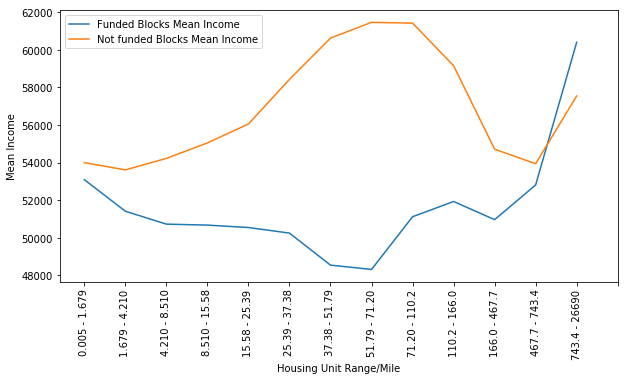

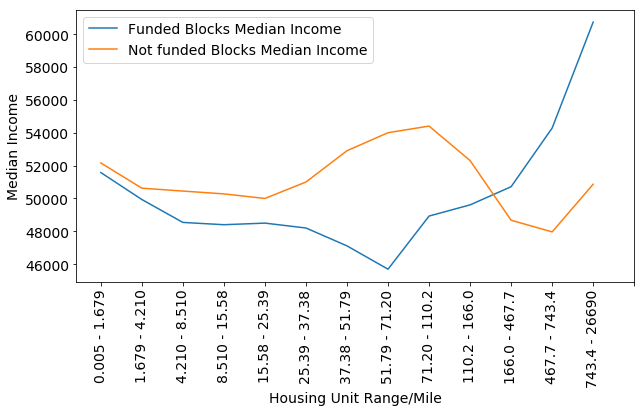

In [97]:
plt.figure(figsize=(10,5))
plt.plot(list(range(len(similar_rural_comp_all))), similar_rural_comp_all.mean_fund, label = 'Funded Blocks Mean Income')
plt.plot(list(range(len(similar_rural_comp_all))), similar_rural_comp_all.mean_no_fund, label = 'Not funded Blocks Mean Income')
plt.legend()
plt.xticks(range(len(bins)), similar_rural_comp_all.housing_units_per_mile_range)
plt.xlabel('Housing Unit Range/Mile')
plt.xticks(rotation=90)
plt.ylabel('Mean Income')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(list(range(len(similar_rural_comp_all))), similar_rural_comp_all.median_fund, label = 'Funded Blocks Median Income')
plt.plot(list(range(len(similar_rural_comp_all))), similar_rural_comp_all.median_no_fund, label = 'Not funded Blocks Median Income')
plt.legend(fontsize=14)
plt.xticks(range(len(bins)), similar_rural_comp_all.housing_units_per_mile_range,fontsize=14)
plt.xlabel('Housing Unit Range/Mile',fontsize=14)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Median Income',fontsize=14)
plt.show()

## Now limit anaysis for areas which didnt previously have access to broadband

In [80]:
val_range = []
median_fund = []
median_no_fund = []
mean_fund = []
mean_no_fund = []
block_count = []

df_block_no_broadband = df_block[(df_block.broadband_access == 0) & (df_block.housing_unit_per_mile > 0)]
for i in range(len(bins)-1):
    temp = df_block_no_broadband[(df_block_no_broadband.housing_unit_per_mile >= bins[i]) &
                                 (df_block_no_broadband.housing_unit_per_mile < bins[i+1])]
    block_count.append(len(temp))
    
    get_fund =  temp[temp.fund_count > 0]
    no_fund = temp[temp.fund_count == 0]
    
    val_range.append(str(bins[i])[0:5] + ' - ' + str(bins[i+1])[0:5])
    median_fund.append(np.median(get_fund.median_household_income_2016.dropna()))
    median_no_fund.append(np.median(no_fund.median_household_income_2016.dropna()))
    mean_fund.append(np.mean(get_fund.median_household_income_2016))
    mean_no_fund.append(np.mean(no_fund.median_household_income_2016))

similar_rural_comp = pd.DataFrame()
similar_rural_comp['housing_units_per_mile_range'] = val_range
similar_rural_comp['median_fund'] = median_fund
similar_rural_comp['median_no_fund'] = median_no_fund
similar_rural_comp['mean_fund'] = mean_fund
similar_rural_comp['mean_no_fund'] = mean_no_fund
similar_rural_comp['block_count'] = block_count


In [81]:
similar_rural_comp

,housing_units_per_mile_range,median_fund,median_no_fund,mean_fund,mean_no_fund,block_count
0,0.005 - 1.679,45593.0,47188.0,47171.366388,49654.418563,118282
1,1.679 - 4.210,43674.0,46197.0,45849.923413,49473.648811,99537
2,4.210 - 8.510,43036.0,46482.0,45631.313808,50377.019799,75394
3,8.510 - 15.58,43400.0,46437.0,45642.706403,51184.251730,50338
4,15.58 - 25.39,44594.5,46458.0,46389.304196,52282.786314,28583
5,25.39 - 37.38,46000.0,46500.0,46383.035857,52696.683211,15620
6,37.38 - 51.79,40708.0,46837.5,42614.977778,53453.806158,9474
7,51.79 - 71.20,49167.0,47250.0,48912.745455,53562.359425,6878
8,71.20 - 110.2,48478.0,46652.0,49772.846154,53067.078530,6839
9,110.2 - 166.0,47031.0,46760.0,53168.440000,52508.195921,4237


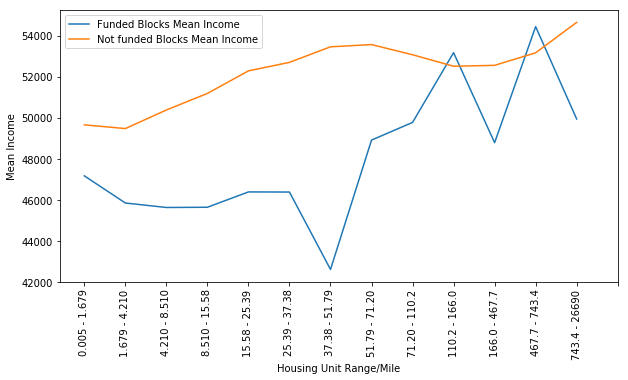

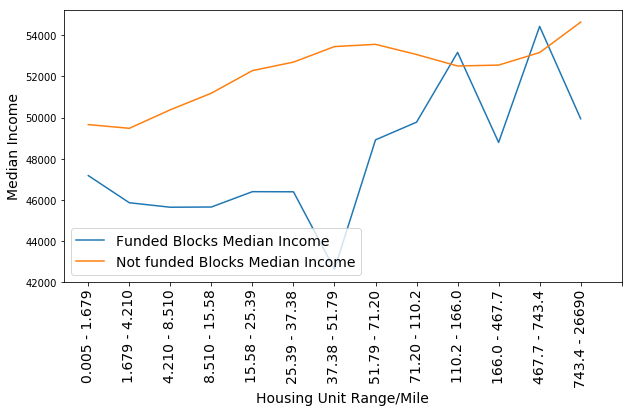

In [94]:
plt.figure(figsize=(10,5))
plt.plot(list(range(len(similar_rural_comp))), similar_rural_comp.mean_fund, label = 'Funded Blocks Mean Income')
plt.plot(list(range(len(similar_rural_comp))), similar_rural_comp.mean_no_fund, label = 'Not funded Blocks Mean Income')
plt.legend()
plt.xticks(range(len(bins)), similar_rural_comp.housing_units_per_mile_range)
plt.xlabel('Housing Unit Range/Mile')
plt.xticks(rotation=90)
plt.ylabel('Mean Income')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(list(range(len(similar_rural_comp))), similar_rural_comp.mean_fund, label = 'Funded Blocks Median Income')
plt.plot(list(range(len(similar_rural_comp))), similar_rural_comp.mean_no_fund, label = 'Not funded Blocks Median Income')
plt.legend(fontsize=14)
plt.xticks(range(len(bins)), similar_rural_comp.housing_units_per_mile_range,fontsize=14)
plt.xlabel('Housing Unit Range/Mile',fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('Median Income',fontsize=14)
plt.show()

# Investigate specific holding companies now
* Above we can see the deviation in income between which areas recieve broadband funding, and which ones don't
* Now we will look to specific holding companies, to see if they deviate significantly from this trend. Are there any which have a clear preference to high income neighborhoods?

In [83]:
#start with top 5 holding companies recieving funding
query = """
SELECT holding_company_name, COUNT(*) as ct FROM broadband.fund
WHERE year = 2017
GROUP BY holding_company_name
ORDER BY ct DESC
LIMIT 5
"""
query_bq(query)

,holding_company_name,ct
0,AT&T Inc.,473552
1,"CenturyLink, Inc.",208688
2,Frontier Communications Corporation,167815
3,"Windstream Holdings, Inc.",54135
4,"FairPoint Communications, Inc.",27946


In [84]:
# this query pulls fund data on the census block level from the top 5 companies
query = """
SELECT 
  census_block, 
  SUM(CASE WHEN holding_company_name = 'AT&T Inc.' THEN 1 ELSE 0 END) AS att_ct,
  SUM(CASE WHEN holding_company_name = 'CenturyLink, Inc.' THEN 1 ELSE 0 END) AS centurylink_ct,
  SUM(CASE WHEN holding_company_name = 'Frontier Communications Corporation' THEN 1 ELSE 0 END) AS frountier_ct,
  SUM(CASE WHEN holding_company_name = 'Windstream Holdings, Inc.' THEN 1 ELSE 0 END) AS windstream_ct,
  SUM(CASE WHEN holding_company_name = 'FairPoint Communications, Inc.' THEN 1 ELSE 0 END) AS fairpoint_ct
FROM broadband.fund
WHERE year = 2017
GROUP BY census_block
"""
hoco_data = query_bq(query)

In [85]:
hoco_data[hoco_data.windstream_ct>0].head()

,census_block,att_ct,centurylink_ct,frountier_ct,windstream_ct,fairpoint_ct
3902,11150405023011,0,0,0,21,0
3903,11150405021083,0,0,0,7,0
3904,11150405023004,0,0,0,5,0
3911,11150404013070,0,0,0,15,0
3913,10510305001002,0,0,0,11,0


In [86]:
# join with exhisting data
df_block = df_block.merge(hoco_data, how='left', left_on = 'block_code',right_on='census_block')


This plot considers the baseline income level for block codes recieving funding, and then compares income for the areas where different holding companies using funding to provide access
* Assumption: These comapanies are large enough such that they dont just have a local presense where they only provide to low/high income aresas

In [87]:
hoco_col =  ['att_ct','centurylink_ct', 'frountier_ct','windstream_ct','fairpoint_ct']
hoco_name = ['AT&T',  'CenturyLink',    'Frountier',   'Windstream',   'Fairpoint']

100%|██████████| 13/13 [00:00<00:00, 306.96it/s]


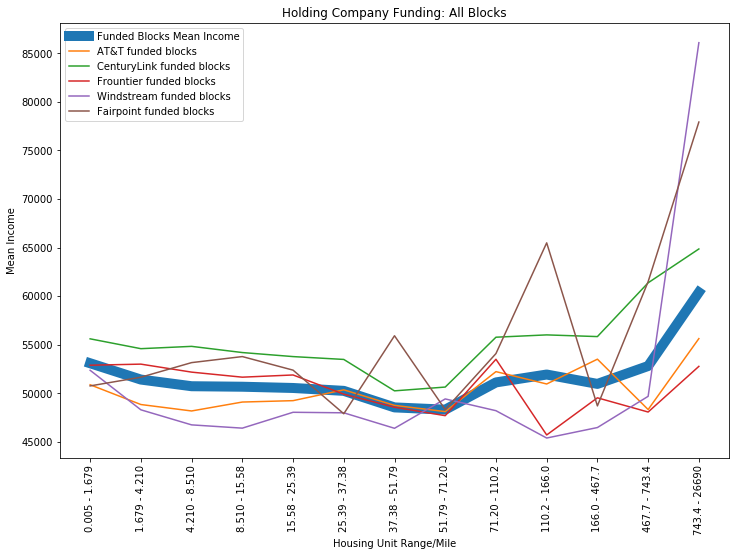

In [88]:
plt.figure(figsize=(12,8))
plt.plot(list(range(len(similar_rural_comp))), similar_rural_comp_all.mean_fund, linewidth=10, label = 'Funded Blocks Mean Income')
plt.xticks(range(len(bins)), similar_rural_comp.housing_units_per_mile_range)
plt.xlabel('Housing Unit Range/Mile')
plt.xticks(rotation=90)
plt.ylabel('Mean Income')
plt.title('Holding Company Funding: All Blocks')

for j in range(len(hoco_col)):
    hoco_blocks = df_block[df_block[hoco_col[j]] > 0]
    
    mean_fund = []

    for i in tqdm(range(len(bins)-1)):
        temp = hoco_blocks[(hoco_blocks.housing_unit_per_mile > 0) &
                           (hoco_blocks.housing_unit_per_mile >= bins[i]) &
                           (hoco_blocks.housing_unit_per_mile < bins[i+1])]
        get_fund =  temp[temp.fund_count > 0]
        mean_fund.append(np.mean(get_fund.median_household_income_2016))
        

    plt.plot(list(range(len(similar_rural_comp_all))), mean_fund, label = hoco_name[j] +' funded blocks')
    
plt.legend()


100%|██████████| 13/13 [00:00<00:00, 222.15it/s]


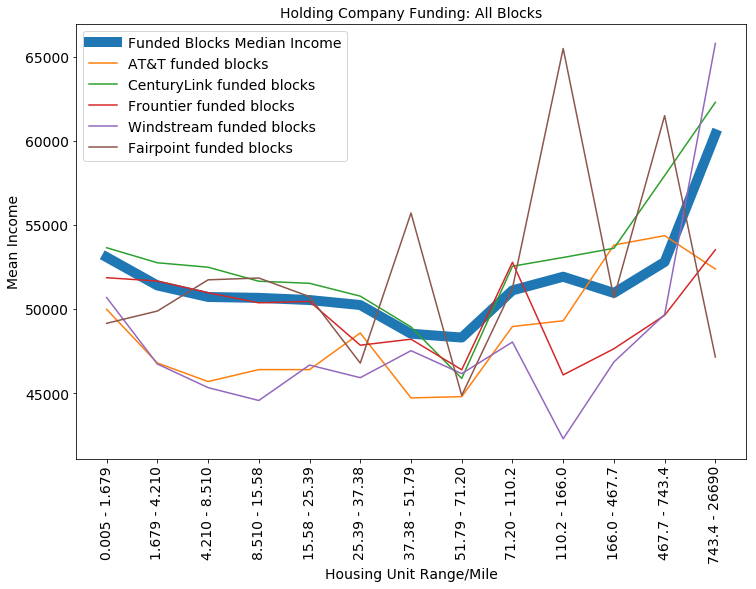

In [102]:
plt.figure(figsize=(12,8))
plt.plot(list(range(len(similar_rural_comp))), similar_rural_comp_all.mean_fund, linewidth=10, label = 'Funded Blocks Median Income')
plt.xticks(range(len(bins)), similar_rural_comp.housing_units_per_mile_range,fontsize=14)
plt.xlabel('Housing Unit Range/Mile',fontsize=14)
plt.xticks(rotation=90,fontsize=14)
plt.ylabel('Mean Income',fontsize=14)
plt.yticks(fontsize=14)
plt.title('Holding Company Funding: All Blocks',fontsize=14)

for j in range(len(hoco_col)):
    hoco_blocks = df_block[df_block[hoco_col[j]] > 0]
    
    median_fund = []

    for i in tqdm(range(len(bins)-1)):
        temp = hoco_blocks[(hoco_blocks.housing_unit_per_mile > 0) &
                           (hoco_blocks.housing_unit_per_mile >= bins[i]) &
                           (hoco_blocks.housing_unit_per_mile < bins[i+1])]
        get_fund =  temp[temp.fund_count > 0]
        median_fund.append(np.median(get_fund.median_household_income_2016.dropna()))
        

    
    plt.plot(list(range(len(similar_rural_comp_all))), median_fund, label = hoco_name[j] +' funded blocks')
    
plt.legend(fontsize=14)


Similar to the previous analysis, now only consider areas which didn't have broadband access in 2016

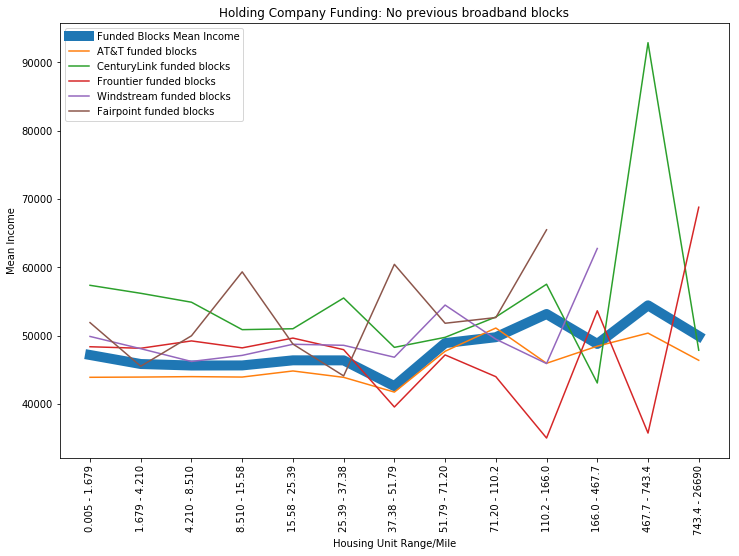

In [92]:
plt.figure(figsize=(12,8))
plt.plot(list(range(len(similar_rural_comp))), similar_rural_comp.mean_fund, linewidth=10, label = 'Funded Blocks Mean Income')
plt.xticks(range(len(similar_rural_comp)), similar_rural_comp.housing_units_per_mile_range)
plt.xlabel('Housing Unit Range/Mile')
plt.xticks(rotation=90)
plt.ylabel('Mean Income')
plt.title('Holding Company Funding: No previous broadband blocks')


df_block_no_broadband = df_block[(df_block.broadband_access == 0) & (df_block.housing_unit_per_mile > 0)]
for j in range(len(hoco_col)):
    hoco_blocks = df_block_no_broadband[df_block_no_broadband[hoco_col[j]] > 0]
    mean_fund = []

    for i in range(len(bins)-1):
        temp = hoco_blocks[(hoco_blocks.housing_unit_per_mile >= bins[i]) &
                           (hoco_blocks.housing_unit_per_mile < bins[i+1])]
        get_fund =  temp[temp.fund_count > 0]

        mean_fund.append(np.mean(get_fund.median_household_income_2016))

    plt.plot(list(range(len(similar_rural_comp))), mean_fund, label = hoco_name[j] +' funded blocks')
    
plt.legend()

/Users/spare/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/spare/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


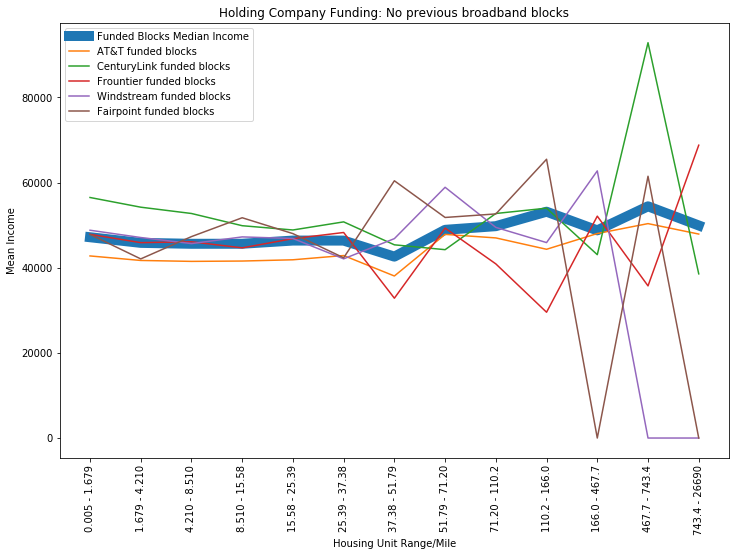

In [93]:
plt.figure(figsize=(12,8))
plt.plot(list(range(len(similar_rural_comp))), similar_rural_comp.mean_fund, linewidth=10, label = 'Funded Blocks Median Income')
plt.xticks(range(len(similar_rural_comp)), similar_rural_comp.housing_units_per_mile_range)
plt.xlabel('Housing Unit Range/Mile')
plt.xticks(rotation=90)
plt.ylabel('Mean Income')
plt.title('Holding Company Funding: No previous broadband blocks')


df_block_no_broadband = df_block[(df_block.broadband_access == 0) & (df_block.housing_unit_per_mile > 0)]
for j in range(len(hoco_col)):
    hoco_blocks = df_block_no_broadband[df_block_no_broadband[hoco_col[j]] > 0]
    median_fund = []

    for i in range(len(bins)-1):
        temp = hoco_blocks[(hoco_blocks.housing_unit_per_mile >= bins[i]) &
                           (hoco_blocks.housing_unit_per_mile < bins[i+1])]
        get_fund =  temp[temp.fund_count > 0]

        median_fund.append(np.median(get_fund.median_household_income_2016.dropna()))

    plt.plot(list(range(len(similar_rural_comp))), median_fund, label = hoco_name[j] +' funded blocks')
    
plt.legend()